# Lab 3: Logistic Regression
### Patrick Yienger, Teresa Yienger,Aviraj Sinha

#### [20 points] Explain the task and what business-case or use-case it is designed to solve (or designed to investigate). 

## Business Understanding

This data set is from The Department of Transportation’s Bureau of Transportation Statistics regarding the On Time Performance of domestic flights flying from the DFW airport from January to March of this year. Since the volume of the original data is so large, we decided to only look at flights from DFW to ORD (Chicago O'Hare) for our model. 

When booking flights for a trip, there are often many different airlines and times of day to choose from. Our classification task is to predict the departure delay group (how long the flight is delayed divided into 3 groups Early, Delay between 0 and 14 minutes, Delay greater than 15 minutes) for each flight based on the Month, Day of Flight, Day of the Week, Departure Time, Airline. The end goal of analysis on our dataset is to be able to understand for an origin and a destination, in our case DFW to ORD, when is the best time to fly and with what airline in order to minimize departure delays when booking a trip. If our model is successful, it could be trained with other origin and destination cities.

### Who would benefit

According to air travel intelligence company, OAG, from April 2017 to March 2018 DFW to ORD was DFW’s second highest grossing route, bringing in $358.4 million in revenue. Thus, it is in the airlines best interest to minimize departure delay and maximize customer satisfaction on this route. Although small delays are inevitable, airlines that fly from DFW could use this analysis to help them see how they stack up to their competitors and to help them better schedule their employees in order to account for probable delays. For example, during times when there is a high likelihood of a delay, they could have more gate and travel agent staff available.


Additionally, businesses who send employees on business trips and people taking personal trips flying from DFW to ORD would benefit from this analysis. If a flight for a business trip gets delayed or cancelled, the company loses money as hours of the client or employee's time are wasted as a result. Additionally, many people get a very limited time for vacation and personal trips. A long delay or cancellation can cause them to lose valuable time at their destination or with their families. Using this analysis a person or company can try to schedule their flights to minimize likelihood of experiencing delays when flying from DFW. If a person has to fly during a time or with an airline with a likelihood of a long delay, they can use this analysis to help them plan accordingly and be sure to build in flexibility due to delays when planning their schedules.

### Model Performance
In order to be considered a useful model, the model will need to be able to accurately predict 90% of the entire dataset. Our model will not be perfect because delay time can be affected by a myriad of factors such as mechanical factors, weather related factors, crew related factors, and the fact that a plane does not just magically appear in an airport but travels from a different destination where it could have also been affected by delays. With the given data our model is unable to account for all of these factors.

Our model would most likely be deployed for internal analysis by the airlines and used for offline analysis by  businesses, and customers planning a trip.

For businesses and people using this model to try and plan their schedules when taking a personal or business trip a number of false negatives (where a flight is predicted to have a large delay but is not delayed) would not be too much of an issue, but a large number of false positives (where a flight is predicted to be early or have little or no delay but is delayed) would be problematic. Although some delays are unavoidable, it is not ethical or useful to the customer to have a large number of false positives. Because of this, our model would have to have a relative rate of around 1% of false positives.

#### [5 points] Define and prepare your class variables. 

In [122]:
import matplotlib
import matplotlib.pyplot as plt
import warnings
warnings.simplefilter('ignore', DeprecationWarning)
%matplotlib inline
import missingno as mn
import pandas as pd
import numpy as np

df = pd.read_csv('DallasToChicago.csv') # read in the csv file
print('Pandas:', pd.__version__)
print('Numpy:',np.__version__)

#Remove attributes that are not useful for us
for col in ['TailNum','FlightNum','OriginAirportID',
           'OriginCityName','OriginState','OriginStateName','DestAirportID','DestCityName','DestState','DestStateName','CRSDepTime',
           'DepDelayMinutes','TaxiIn','TaxiOut','CRSArrTime','ArrTime','ArrDelay','ArrDelayMinutes','ArrDelayGroup','ATimeBlk','CancellationReason',
            'Diverted', 'AirTime','CarrierDelay','WeatherDelay','NASDelay','SecurityDelay','LateAircraftDelay','FirstDepTime1','FirstDepTime2',
            'FirstDepTime','TotalAddGTime','LongestAddGTime','DivAirportLandings','DivReachedDest','DivActualElapsedTime','DivArrDelay','DivDistance',
           'CRSElapsedTime','Flights','Cancelled','Unnamed: 0', 'Distance', 'DistGroup', 'ActualElapsedTime']:
    if col in df:
        del df[col]

Pandas: 0.23.4
Numpy: 1.13.1


In [123]:
print(df.info(verbose=True, null_counts=True))


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1828 entries, 0 to 1827
Data columns (total 15 columns):
Year             1828 non-null int64
Quarter          1828 non-null int64
Month            1828 non-null int64
monthname        1828 non-null object
DayofMonth       1828 non-null int64
DayOfWeek        1828 non-null int64
dayname          1828 non-null object
FlightDate       1828 non-null object
airline          1828 non-null object
Origin           1828 non-null object
Dest             1828 non-null object
DepTime          1811 non-null object
DepDelay         1811 non-null float64
DepDelayGroup    1811 non-null object
DTimeBlk         1828 non-null object
dtypes: float64(1), int64(5), object(9)
memory usage: 214.3+ KB
None


In [124]:
#Figure out what data is missing
df.isnull().sum()

Year              0
Quarter           0
Month             0
monthname         0
DayofMonth        0
DayOfWeek         0
dayname           0
FlightDate        0
airline           0
Origin            0
Dest              0
DepTime          17
DepDelay         17
DepDelayGroup    17
DTimeBlk          0
dtype: int64

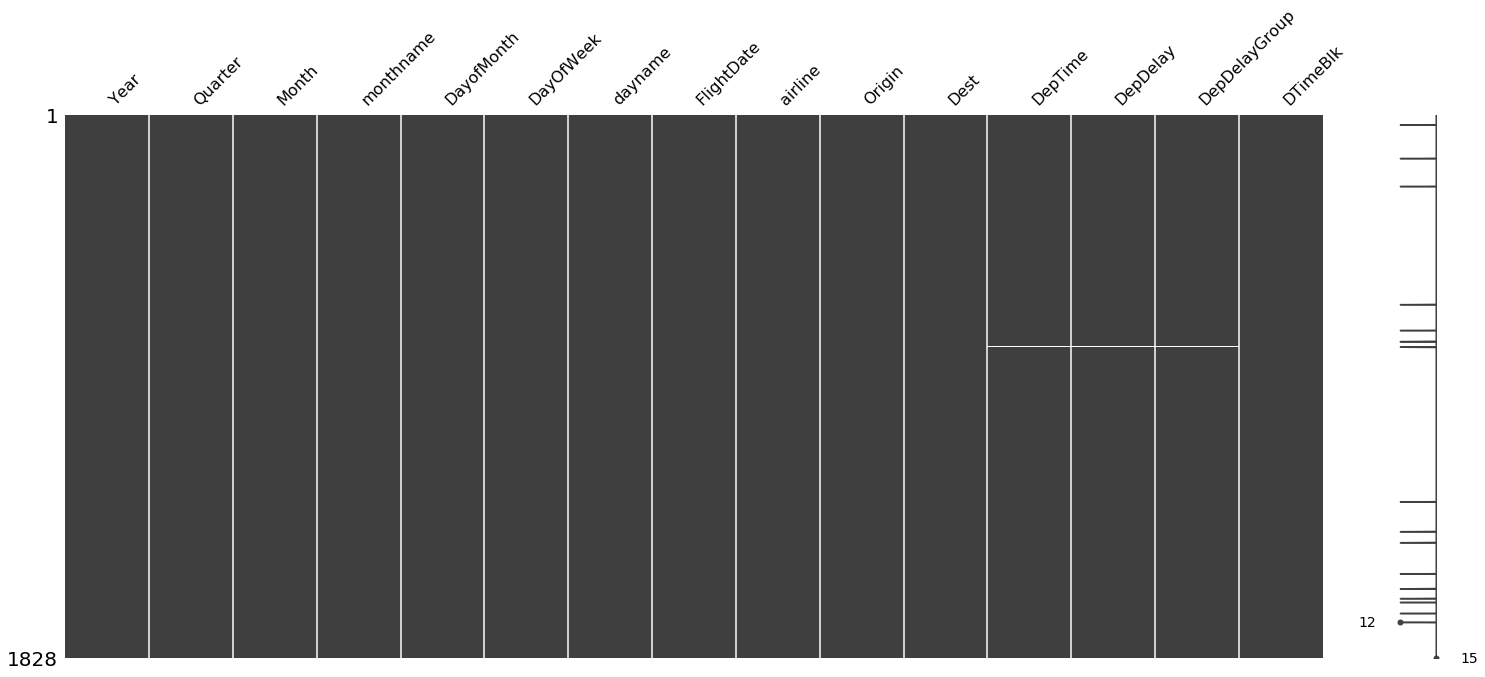

In [125]:
mn.matrix(df)

In [126]:
#Remove the missing data
df.dropna(inplace=True)
df.count()

Year             1811
Quarter          1811
Month            1811
monthname        1811
DayofMonth       1811
DayOfWeek        1811
dayname          1811
FlightDate       1811
airline          1811
Origin           1811
Dest             1811
DepTime          1811
DepDelay         1811
DepDelayGroup    1811
DTimeBlk         1811
dtype: int64

In [127]:
print(df.shape)
df.dtypes

(1811, 15)


Year               int64
Quarter            int64
Month              int64
monthname         object
DayofMonth         int64
DayOfWeek          int64
dayname           object
FlightDate        object
airline           object
Origin            object
Dest              object
DepTime           object
DepDelay         float64
DepDelayGroup     object
DTimeBlk          object
dtype: object

In [128]:
#see explained variance
import numpy as np
def plot_explained_variance(pca):
    import plotly
    from plotly.graph_objs import Bar, Line
    from plotly.graph_objs import Scatter, Layout
    from plotly.graph_objs.scatter import Marker
    from plotly.graph_objs.layout import XAxis, YAxis
    plotly.offline.init_notebook_mode() # run at the start of every notebook

    explained_var = pca.explained_variance_ratio_
    cum_var_exp = np.cumsum(explained_var)

    plotly.offline.iplot({
        "data": [Bar(y=explained_var, name='individual explained variance'),
                 Scatter(y=cum_var_exp, name='cumulative explained variance')
            ],
        "layout": Layout(xaxis=XAxis(title='Principal components'), yaxis=YAxis(title='Explained variance ratio'))
    })

features = ['Year','Quarter','Month' ,'DayofMonth','DayOfWeek','DepDelay']



In [129]:
import datetime
import time

def time_converter(t):
    x = time.strptime(t.split(',')[0],'%H:%M')
    return int(datetime.timedelta(hours=x.tm_hour,minutes=x.tm_min,seconds=x.tm_sec).total_seconds())

df["RealDepTime"] = df.apply( lambda row: time_converter(row.DepTime), axis=1)


cleaned_df = df[['Month' ,'airline','DayofMonth','DayOfWeek', 'DepDelayGroup','RealDepTime']]
columns = cleaned_df # Declare the columns names
#y = columns

#one hot encode airline
temp_df = pd.get_dummies(cleaned_df.airline,prefix='airline')
cleaned_df = pd.concat((cleaned_df,temp_df),axis=1)

if 'airline' in cleaned_df:
    del cleaned_df['airline'] # get rid of the original category as it is now one-hot encoded
    
#condense categories of Departure Delay
cleaned_df['DepDelayGroup'] = cleaned_df['DepDelayGroup'].replace("Delay < -15 minutes","Early")
cleaned_df['DepDelayGroup'] = cleaned_df['DepDelayGroup'].replace("Delay between -15 and -1 minutes","Early")
cleaned_df['DepDelayGroup'] = cleaned_df['DepDelayGroup'].replace("Delay between 15 to 29 minutes","Delay greater than 15 minutes")
cleaned_df['DepDelayGroup'] = cleaned_df['DepDelayGroup'].replace("Delay between 30 to 44 minutes","Delay greater than 15 minutes")
cleaned_df['DepDelayGroup'] = cleaned_df['DepDelayGroup'].replace("Delay between 45 to 59 minutes","Delay greater than 15 minutes")
cleaned_df['DepDelayGroup'] = cleaned_df['DepDelayGroup'].replace("Delay between 60 to 74 minutes","Delay greater than 15 minutes")
cleaned_df['DepDelayGroup'] = cleaned_df['DepDelayGroup'].replace("Delay between 75 to 89 minutes","Delay greater than 15 minutes")
cleaned_df['DepDelayGroup'] = cleaned_df['DepDelayGroup'].replace("Delay between 90 to 104 minutes","Delay greater than 15 minutes")
cleaned_df['DepDelayGroup'] = cleaned_df['DepDelayGroup'].replace("Delay between 105 to 119 minutes","Delay greater than 15 minutes")
cleaned_df['DepDelayGroup'] = cleaned_df['DepDelayGroup'].replace("Delay between 120 to 134 minutes","Delay greater than 15 minutes")
cleaned_df['DepDelayGroup'] = cleaned_df['DepDelayGroup'].replace("Delay between 135 to 149 minutes","Delay greater than 15 minutes")
cleaned_df['DepDelayGroup'] = cleaned_df['DepDelayGroup'].replace("Delay between 150 to 164 minutes","Delay greater than 15 minutes")
cleaned_df['DepDelayGroup'] = cleaned_df['DepDelayGroup'].replace("Delay between 165 to 179 minutes","Delay greater than 15 minutes")
cleaned_df['DepDelayGroup'] = cleaned_df['DepDelayGroup'].replace("Delay >= 180 minutes","Delay greater than 15 minutes")


In [130]:
from sklearn.preprocessing import StandardScaler
# Separating out the features
x = df.loc[:, features].values
# Standardizing the features
x = StandardScaler().fit_transform(x)

from sklearn.decomposition import PCA

pca = PCA(n_components=6)
X_pca = pca.fit(x)
plot_explained_variance(pca)


IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.


In [131]:
from sklearn.preprocessing import LabelEncoder
number = LabelEncoder()
cleaned_df['DepDelayGroupA'] = number.fit_transform(cleaned_df['DepDelayGroup'].astype('str'))

#show the value that coorsponds to original groups
comp_df = cleaned_df[['DepDelayGroup' ,'DepDelayGroupA']]
print(comp_df.drop_duplicates())


                    DepDelayGroup  DepDelayGroupA
0   Delay greater than 15 minutes               1
1  Delay between 0 and 14 minutes               0
3                           Early               2


In [132]:
if 'DepDelayGroup' in cleaned_df:
    del cleaned_df['DepDelayGroup'] # get rid of the original category as it is now one-hot encoded
cleaned_df.head()

,Month,DayofMonth,DayOfWeek,RealDepTime,airline_American Airlines Inc.,airline_Republic Airline,airline_SkyWest Airlines Inc.,airline_Spirit Air Lines,airline_United Air Lines Inc.,DepDelayGroupA
0,1,1,1,41340,1,0,0,0,0,1
1,1,2,2,38100,1,0,0,0,0,0
2,1,3,3,39240,1,0,0,0,0,1
3,1,4,4,37680,1,0,0,0,0,2
4,1,5,5,38220,1,0,0,0,0,0


### Describe the final dataset that is used for classification/regression (include a description of any newly formed variables you created).
Initial Dataset:
* month (the day of the week of the flight) -----------------------> ordinal
* dayofmonth (the day of the week of the flight) -----------------------> ordinal
* dayofweek (the day of the week of the flight) -----------------------> ordinal
* airline (the airline of the flight)--------------------------------> nominal
* Origin (origin airport code of the flight)-------------------------> nominal
* Dest (destination airport code of the flight)----------------------> nominal
* DepTime (departure time of the flight)-----------------------------> ratio
* DepDelay (delay of the flight departure in minutes)----------------> interval
* DepDelayGroup (delay of the flight departure grouped by minutes)---> ordinal
* DTimeBlk (delay of the flight grouped by hours)--------------------> ordinal
* ActualElapsedTime (flight time in the air)-------------------------> ratio
* Distance (distance the flight travelled)---------------------------> interval
* DistGroup (distance the flight travelled grouped by miles----------> ordinal

Final Dataset: 
* month (the day of the week of the flight) -----------------------> int
* dayofmonth (the day of the week of the flight) -----------------------> int
* dayofweek (the day of the week of the flight) -----------------------> int
* airline (the airline of the flight)--------------------------------> one-hot encoded
* DepTime (departure time of the flight in seconds)-----------------------------> float
* DepDelayGroup (delay of the flight departure grouped by minutes)---> int

We decided to pair down the 15 groups of the Departure Delay Group Category into 3 main groups (Early, Delay between 0 and 14 minutes, Delay greater than 15 minutes) in order to have a better balance of data points for the categories. This is because some categories only had a few datapoints- one as low as 3, and one as high as 1100 data points.
Our new groups have 413, 287, and 1111 datapoints respectively. Although this is not perfectly balanced, it will help us to accurately run our regression without bias towards the largest category (before it was classifying almost all data points as the category with the most data).

#### [5 points] Divide your data into training and testing data using an 80% training and 20% testing split. 

In [133]:
from sklearn.model_selection import ShuffleSplit
#normalize data
if 'DepDelayGroupA' in cleaned_df:
    y = cleaned_df['DepDelayGroupA'].values # get the labels we want
    del cleaned_df['DepDelayGroupA'] # get rid of the class label
    norm_features = ['Month','DayofMonth','DayOfWeek','RealDepTime' ]
    cleaned_df[norm_features] = (cleaned_df[norm_features]-cleaned_df[norm_features].mean()) / cleaned_df[norm_features].std()
    X = cleaned_df.values # use everything else to predict!

In [134]:
#Data is imbalanced
from collections import Counter
print(sorted(Counter(y).items()))

[(0, 413), (1, 287), (2, 1111)]


In [135]:
num_cv_iterations = 1
num_instances = len(y)
cv_object = ShuffleSplit(
                         n_splits=num_cv_iterations,
                         test_size  = 0.2)
#split into train and test
X_trainOrig, X_train, y_trainOrig, y_train, X_test, y_test = ([] for i in range(6))

for train_indices, test_indices in cv_object.split(X,y):
    X_trainOrig = X[train_indices]
    y_trainOrig = y[train_indices]
    #oversample the data
    from imblearn.over_sampling import RandomOverSampler
    ros = RandomOverSampler(random_state=0)
    X_resampled, y_resampled = ros.fit_sample(X_trainOrig,y_trainOrig)
    print(sorted(Counter(y_resampled).items()))
    X_train = X_resampled
    y_train = y_resampled
    
    X_test = X[test_indices]
    y_test = y[test_indices]

[(0, 884), (1, 884), (2, 884)]


### Why did we oversample the data?
We oversampled the data because the data was very imbalanced. Because of the imbalance, the regression was always guessing a delay between 0 and 14 minutes and never was choosing another delay category. This is bad because all of the regressions were showing extreme bias towards the largest category (before it was classifying almost all data points as the category with the most data). To do the oversampling, we decided to oversample and balance the data for only the training data set, instead of oversamping the whole data set to prevent the same data point from ending up in both the training and testing data sets. 

### Explanation of training split
Using an 80:20 testing and training split is not ideal for our data set as many of the categories we are using to predict the data are time series dependent for example Month, Departure Time, Day of Month and Shuffle Split's 80:20 split randomly seperates the data.

#### [20 points] Create a custom, one-versus-all logistic regression classifier using numpy and scipy to optimize. 

In [136]:
# BLR
#inherit from base class
# from last time, our logistic regression algorithm is given by (including everything we previously had):
from sklearn import metrics as mt
from scipy.special import expit
from numpy.linalg import pinv
class BinaryLogisticRegression:
    def __init__(self, eta, iterations=20, C=0.001, optChoice='steepest', reg_choice = "o"):
        self.eta = eta
        self.iters = iterations
        self.C = C
        self.optChoice = optChoice
        self.reg_choice = reg_choice
        # internally we will store the weights as self.w_ to keep with sklearn conventions

    def __str__(self):
        if(hasattr(self,'w_')):
            return 'Binary Logistic Regression Object with coefficients:\n'+ str(self.w_) # is we have trained the object
        else:
            return 'Untrained Binary Logistic Regression Object'

    # convenience, private:
    @staticmethod
    def _add_bias(X):
        return np.hstack((np.ones((X.shape[0],1)),X)) # add bias term

    @staticmethod
    def _sigmoid(theta):
        # increase stability, redefine sigmoid operation
        return expit(theta) #1/(1+np.exp(-theta))


    # public:
    def predict_proba(self,X,add_bias=True):
        # add bias term if requested
        Xb = self._add_bias(X) if add_bias else X
        return self._sigmoid(Xb @ self.w_) # return the probability y=1

    def predict(self,X):
        return (self.predict_proba(X)>0.5) #return the actual prediction


    def fit(self, X, y):
        Xb = self._add_bias(X) # add bias term
        num_samples, num_features = Xb.shape

        self.w_ = np.zeros((num_features,1)) # init weight vector to zeros

        # for as many as the max iterations
        for _ in range(self.iters):
            gradient = self._get_gradient(Xb,y)
            self.w_ += gradient*self.eta # multiply by learning rate

    # public:
    def fit(self, X, y):
        Xb = self._add_bias(X) # add bias term
        num_samples, num_features = Xb.shape

        self.w_ = np.zeros((num_features,1)) # init weight vector to zeros

        # for as many as the max iterations
        for _ in range(self.iters):
            gradient = self._get_gradient(Xb,y)
            self.w_ += gradient*self.eta # multiply by learning rate


In [137]:
#Vector BinaryLogisticRegression
class VectorBinaryLogisticRegression(BinaryLogisticRegression):
    # inherit from our previous class to get same functionality
    @staticmethod
    def _sigmoid(theta):
        # increase stability, redefine sigmoid operation
        return expit(theta) #1/(1+np.exp(-theta))

    # but overwrite the gradient calculation
    def _get_gradient(self,X,y):
        if self.optChoice == 'steepest':
            ydiff = y-self.predict_proba(X,add_bias=False).ravel() # get y difference
            gradient = np.mean(X * ydiff[:,np.newaxis], axis=0) # make ydiff a column vector and multiply through
            gradient = gradient.reshape(self.w_.shape)


            l_choice = self.reg_choice
            if l_choice == "o":
                gradient += gradient.reshape(self.w_.shape)
            elif l_choice == "l1":
                gradient[1:] += -np.sin(self.w_[1:]) * self.C
            elif l_choice == "l2":
                gradient[1:] += -2 * self.w_[1:] * self.C
            elif l_choice == "both":
                gradient[1:] += (-np.sin(self.w_[1:]) + (-2 * self.w_[1:])) * self.C

            return gradient
        elif self.optChoice == 'stochastic':
            # stochastic gradient calculation
            idx = int(np.random.rand()*len(y)) # grab random instance
            ydiff = y[idx]-self.predict_proba(X[idx],add_bias=False) # get y difference (now scalar)
            gradient = X[idx] * ydiff[:,np.newaxis] # make ydiff a column vector and multiply through
            gradient = gradient.reshape(self.w_.shape)


            l_choice = self.reg_choice
            if l_choice == "o":
                gradient += gradient.reshape(self.w_.shape)
            elif l_choice == "l1":
                gradient[1:] += -np.sin(self.w_[1:]) * self.C
            elif l_choice == "l2":
                gradient[1:] += -2 * self.w_[1:] * self.C
            elif l_choice == "both":
                gradient[1:] += (-np.sin(self.w_[1:]) + (-2 * self.w_[1:])) * self.C


            return gradient
        elif self.optChoice == 'newtonHessian':
            g = self.predict_proba(X,add_bias=False).ravel() # get sigmoid value for all classes
            hessian = X.T @ np.diag(g*(1-g)) @ X - 2 * self.C # calculate the hessian
            ydiff = y-g # get y difference
            gradient = np.sum(X * ydiff[:,np.newaxis], axis=0) # make ydiff a column vector and multiply through
            gradient = gradient.reshape(self.w_.shape)

            l_choice = self.reg_choice
            if l_choice == "o":
                gradient += gradient.reshape(self.w_.shape)
            elif l_choice == "l1":
                gradient[1:] += -np.sin(self.w_[1:]) * self.C
            elif l_choice == "l2":
                gradient[1:] += -2 * self.w_[1:] * self.C
            elif l_choice == "both":
                gradient[1:] += (-np.sin(self.w_[1:]) + (-2 * self.w_[1:])) * self.C

            return pinv(hessian) @ gradient


In [138]:
#Logistic Regression
class LogisticRegression:
    def __init__(self, eta, iterations=20, C=0.001, optChoice='steepest', reg_choice="o"):
        self.eta = eta
        self.iters = iterations
        self.C = C
        self.optChoice = optChoice
        self.reg_choice = reg_choice
        # internally we will store the weights as self.w_ to keep with sklearn conventions

    def __str__(self):
        if(hasattr(self,'w_')):
            return 'MultiClass Logistic Regression Object with coefficients:\n'+ str(self.w_) # is we have trained the object
        else:
            return 'Untrained MultiClass Logistic Regression Object'

    def fit(self,X,y):
        num_samples, num_features = X.shape
        self.unique_ = np.unique(y) # get each unique class value
        num_unique_classes = len(self.unique_)
        self.classifiers_ = [] # will fill this array with binary classifiers

        for i,yval in enumerate(self.unique_): # for each unique value
            y_binary = y==yval # create a binary problem
            # train the binary classifier for this class
            blr = VectorBinaryLogisticRegression(self.eta,self.iters,self.C,self.optChoice, self.reg_choice)
            blr.fit(X,y_binary)
            # add the trained classifier to the list
            self.classifiers_.append(blr)

        # save all the weights into one matrix, separate column for each class
        self.w_ = np.hstack([x.w_ for x in self.classifiers_]).T

    def predict_proba(self,X):
        probs = []
        for blr in self.classifiers_:
            probs.append(blr.predict_proba(X)) # get probability for each classifier

        return np.hstack(probs) # make into single matrix

    def predict(self,X):
        return np.argmax(self.predict_proba(X),axis=1) # take argmax along row


#### [15 points] Train your classifier to achieve good generalization performance.

In [139]:
#helper function to test multiple C values
import numpy as np
def getCArray(beginC, endC, stepSize):
    cArr = []
    for i in np.arange(beginC, endC, stepSize).tolist():
        cArr.append(i)
    return cArr


In [140]:
cmArr = []
def find_best_C(beginC, endC, stepSize, X_train, y_train,X_test,y_test, regression):
    accuracyArr = []
    for i in np.arange(beginC, endC, stepSize).tolist():
        #Choose the optimization and the L term
        if (regression == "lr_steep0"):
            lr = LogisticRegression(eta=0.1, C = i)
        elif (regression == "lr_steep1"):
            lr = LogisticRegression(eta=0.1,C = i,reg_choice = "l1")
        elif (regression == "lr_steep2"):
            lr = LogisticRegression(eta=0.1, C = i, reg_choice = "l2")
        elif (regression == "lr_steepb"):
            lr = LogisticRegression(eta=0.1, C= i, reg_choice = "both")
        elif (regression == "lr_scho0"):
            lr = LogisticRegression(eta=0.1,iterations=1500,C = i, optChoice = 'stochastic')
        elif (regression == "lr_scho1"):
            lr = LogisticRegression(eta=0.1,iterations=1500, C = i, optChoice = 'stochastic',reg_choice = "l1")
        elif (regression == "lr_scho2"):
            lr = LogisticRegression(eta=0.1,iterations=1500, C = i, optChoice = 'stochastic',reg_choice = "l2")
        elif (regression == "lr_schob"):
            lr = LogisticRegression(eta=0.1,iterations=1500, C = i, optChoice = 'stochastic',reg_choice = "both")
        elif (regression == "lr_nh0"):
            lr = LogisticRegression(eta=0.1,iterations=1, C = i, optChoice = 'newtonHessian')
        elif (regression == "lr_nh1"):
            lr = LogisticRegression(eta=0.1,iterations=1, C = i, optChoice = 'newtonHessian',reg_choice = "l1")
        elif (regression == "lr_nh2"):
            lr = LogisticRegression(eta=0.1,iterations=1, C = i, optChoice = 'newtonHessian',reg_choice = "l2")
        elif (regression == "lr_nhb"):
            lr = LogisticRegression(eta=0.1,iterations=1, C = i, optChoice = 'newtonHessian',reg_choice = "both")
        lr.fit(X_train,y_train)  # train object
        y_hat = lr.predict(X_test) # get test set precitions
        acc = mt.accuracy_score(y_test,y_hat)
        accuracyArr.append(acc)
        cmArr.append(metrics.confusion_matrix(y_test, y_hat))
    return accuracyArr

Steepest-Orig :


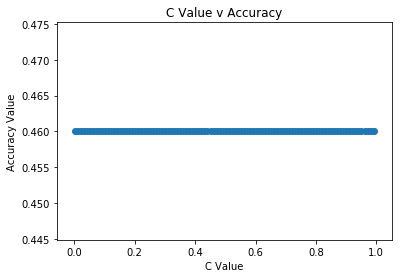

max accuracy:  0.460055096419
c value:  0.001
Steepest-1 :


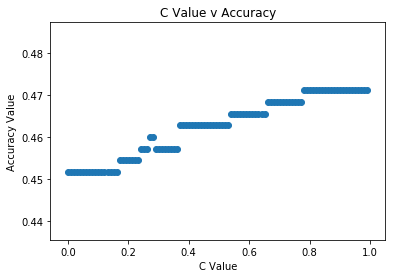

max accuracy:  0.471074380165
c value:  0.7809999999999999
Steepest-2 :


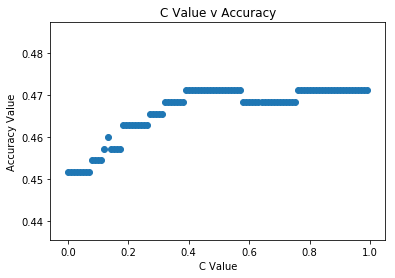

max accuracy:  0.471074380165
c value:  0.39099999999999996
Steepest-B :


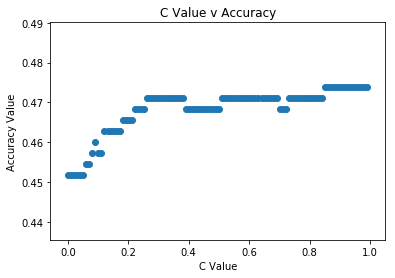

max accuracy:  0.473829201102
c value:  0.8509999999999999
Stochastic-Orig: 


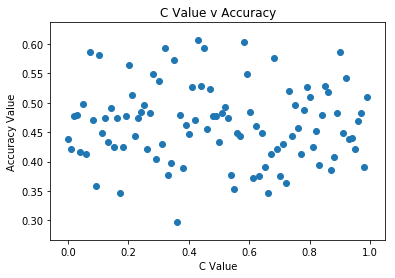

max accuracy:  0.606060606061
c value:  0.43099999999999994
Stochastic-1: 


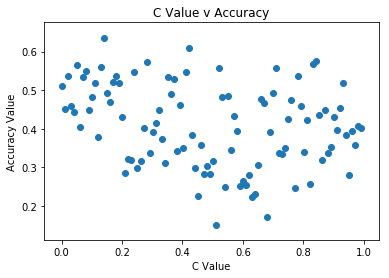

max accuracy:  0.636363636364
c value:  0.141
Stochastic-2: 


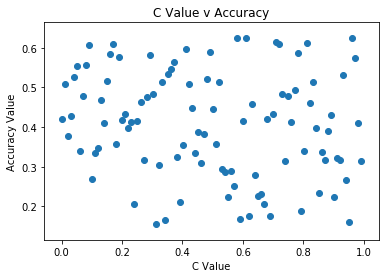

max accuracy:  0.625344352617
c value:  0.581
Stochastic-B: 


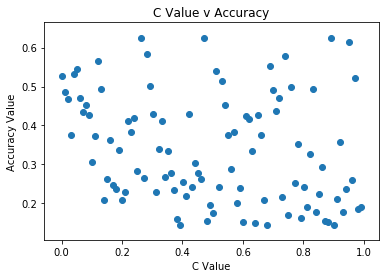

max accuracy:  0.625344352617
c value:  0.26099999999999995
NewtonHessian-Orig: 


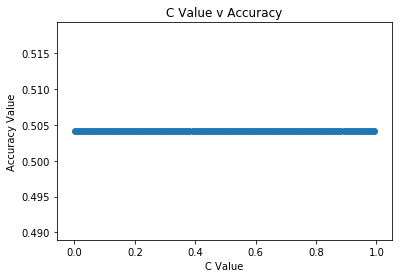

max accuracy:  0.504132231405
c value:  0.001
NewtonHessian-1: 


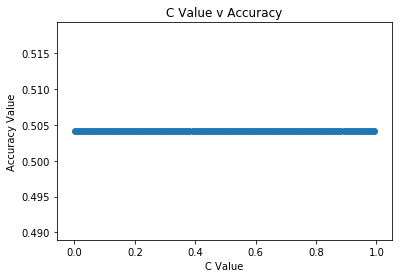

max accuracy:  0.504132231405
c value:  0.001
NewtonHessian-2: 


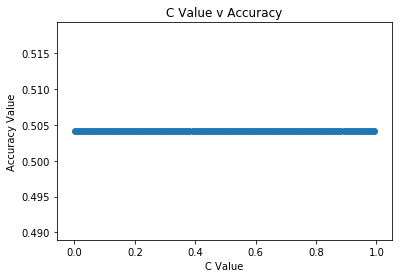

max accuracy:  0.504132231405
c value:  0.001
NewtonHessian-B: 


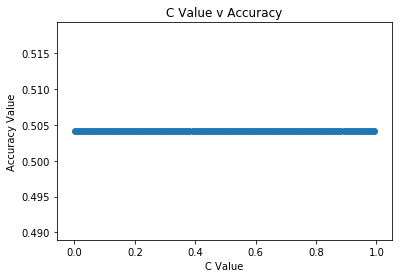

max accuracy:  0.504132231405
c value:  0.001


In [141]:
regListName = ["Steepest-Orig :", "Steepest-1 :", "Steepest-2 :", "Steepest-B :", "Stochastic-Orig: ", "Stochastic-1: ", "Stochastic-2: ", "Stochastic-B: ", "NewtonHessian-Orig: ", "NewtonHessian-1: ", "NewtonHessian-2: ", "NewtonHessian-B: "]
regList = ["lr_steep0", "lr_steep1", "lr_steep2", "lr_steepb", "lr_scho0", "lr_scho1", "lr_scho2", "lr_schob", "lr_nh0", "lr_nh1", "lr_nh2", "lr_nhb"]
cList = [0.001,1,0.01]
i = 0
bestC = []
bestAccuracyScore = []
bestCM = []
for r in regList:
    regArr = find_best_C(beginC = cList[0], endC = cList[1], stepSize = cList[2], X_train = X_train, y_train = y_train, X_test = X_test,y_test = y_test, regression = r)
    cArr = getCArray(beginC = cList[0], endC = cList[1], stepSize = cList[2])
    print(regListName[i])
    plt.scatter(cArr, regArr)
    plt.xlabel("C Value")
    plt.ylabel("Accuracy Value")
    plt.title("C Value v Accuracy")
    plt.show()
    print("max accuracy: " , max(regArr))
    bestAccuracyScore.append(max(regArr))
    c_value_index = regArr.index(max(regArr))
    bestC.append(cArr[c_value_index])
    bestCM.append(cmArr[c_value_index])
    print("c value: ", cArr[c_value_index])
    cmArr = []
    i+=1


In [142]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics
def best_c_confusion(i):

    cm = bestCM[i]
    acc = bestAccuracyScore[i]
    plt.figure(figsize=(10,5))
    sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r')
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')
    all_sample_title = regListName[i] + 'Accuracy Score: {0}'.format(acc)
    plt.title(all_sample_title, size = 15)
    plt.show()

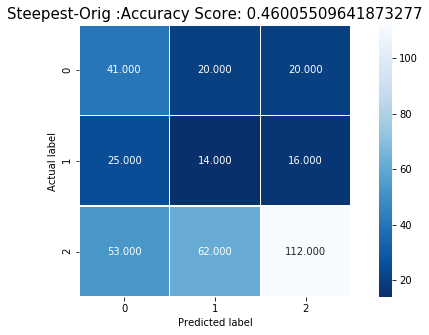

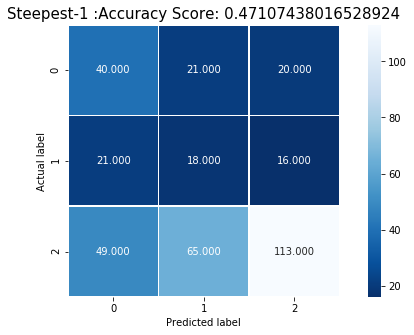

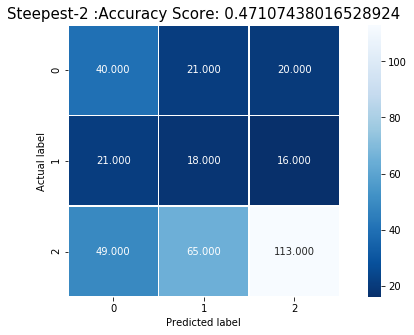

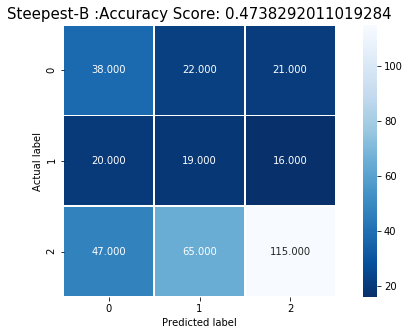

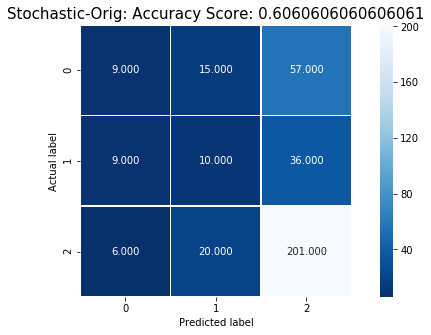

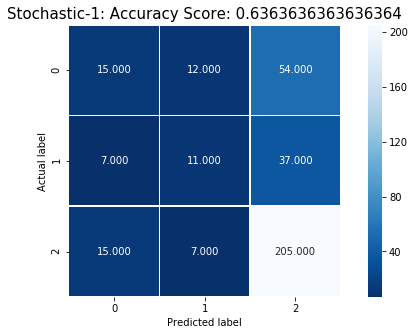

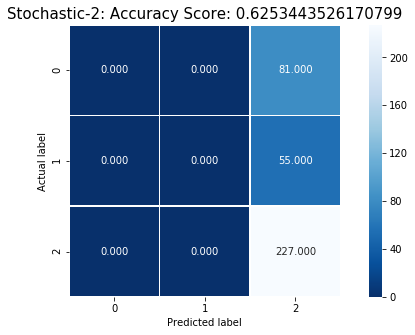

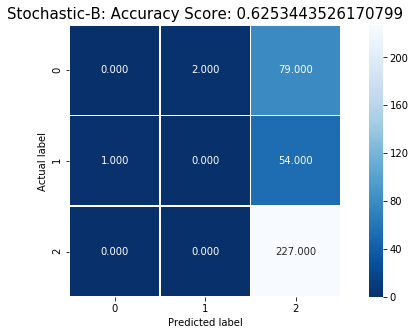

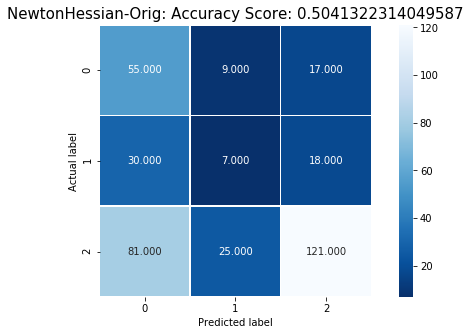

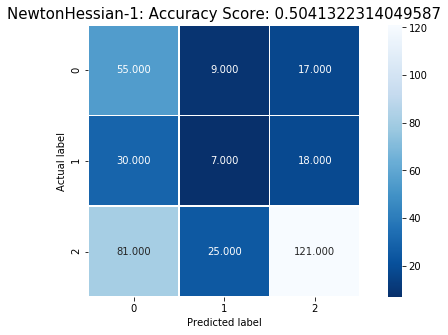

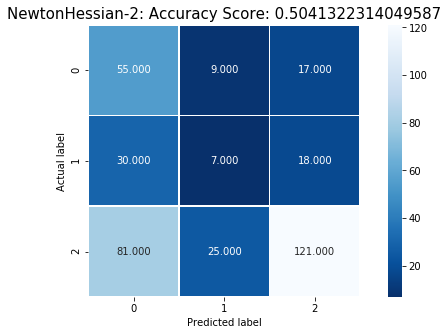

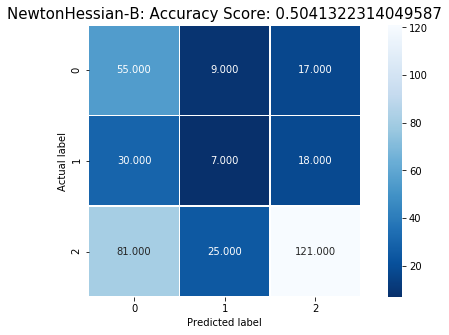

In [143]:
#show confusion matrix for each method
i = 0
for r in regList:
    best_c_confusion(i)
    i+=1

### Is your method of selecting parameters justified? That is, do you think there is any "data snooping" involved with this method of selecting parameters?
No, our method of selecting parameters is not justified as we are data snooping to the extreme. Our technique of selecting every permutation of parameters and choosing the best combination possible is biased because the parameters are overfitted only for our dataset. The parameters selected that were optimal for this dataset of flights may not be optimal for another.

#### [15 points] Compare the performance of your "best" logistic regression optimization procedure to the procedure used in scikit-learn.  

In [144]:
def plot_confusion_scikit(y,yhat):
    cm = metrics.confusion_matrix(y, yhat)
    plt.figure(figsize=(10,5))
    sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r')
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')
    all_sample_title = 'Accuracy Score: {0}'.format(accuracy_score(y,yhat))
    plt.title(all_sample_title, size = 15)
    plt.show()

Accuracy of:  0.506887052342


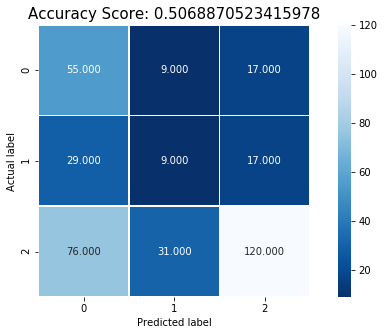

In [145]:
from sklearn.linear_model import LogisticRegression as SKLogisticRegression
from sklearn.metrics import accuracy_score
lr_sk = SKLogisticRegression() # all params default
lr_sk.fit(X_train,y_train)
yhat = lr_sk.predict(X_test)
print('Accuracy of: ',accuracy_score(y_test,yhat))
#show confusion matrix for scikit learn
plot_confusion_scikit(y_test,yhat)


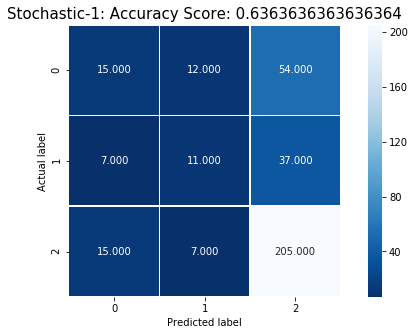

0.141


In [146]:
#show confusion matrix and accuracy score for best regression
i = bestAccuracyScore.index(max(bestAccuracyScore))
best_c_confusion(i)
print(bestC[i])

Stochasitic Org accuracy 0.41247933884297516; time: 0.09721728801727295
Scikit Org accuracy 0.4958842975206612; time: 0.00793737554550171


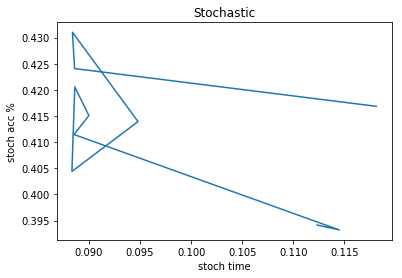

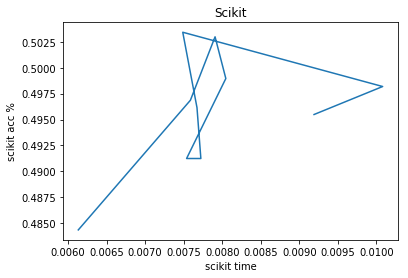

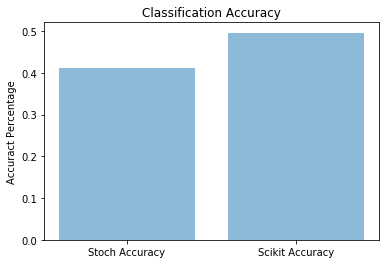

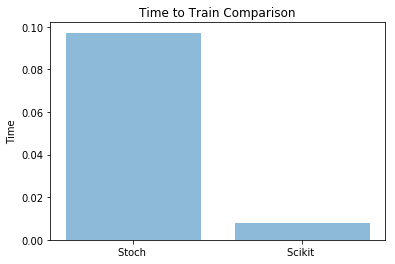

In [147]:
lr_sk = SKLogisticRegression() # all params default


num_cv_iterations = 50
num_instances = len(y)
cv_object = ShuffleSplit( n_splits=num_cv_iterations, test_size  = 0.2)
# run logistic regression and vary some parameters
from sklearn import metrics as mt

# first we create a reusable logisitic regression object
#   here we can setup the object with different learning parameters and constants
lr_clf = LogisticRegression(eta=0.1,iterations=1500,C = bestC[i], optChoice = 'stochastic', reg_choice = "both") # get object

# now we can use the cv_object that we setup before to iterate through the
#    different training and testing sets. Each time we will reuse the logisitic regression
#    object, but it gets trained on different data each time we use it.

import time

X_trainOrig, X_train, y_trainOrig, y_train, X_test, y_test = ([] for i in range(6))




iter_num=1
# the indices are the rows used for training and testing in each iteration
stoch_time, scikit_time, stoch_acc, scikit_acc = [], [], [], []
for i in range(10):
    for train_indices, test_indices in cv_object.split(X,y):
        X_trainOrig = X[train_indices][:int(len(X) * (iter_num/50.))]
        y_trainOrig = y[train_indices][:int(len(X) * (iter_num/50.))]

        
        from imblearn.over_sampling import RandomOverSampler
        ros = RandomOverSampler(random_state=0)
        X_resampled, y_resampled = ros.fit_sample(X_trainOrig,y_trainOrig)
        X_train = X_resampled
        y_train = y_resampled
        
        X_test = X[test_indices]
        y_test = y[test_indices]
        # train the reusable logisitc regression model on the training data
        t0 = time.time()
        lr_sk.fit(X_train,y_train)  # train object
        y_hat = lr_sk.predict(X_test) # get test set precitions
        t1 = time.time()

        total_scikit = t1-t0
        scikit_time.append(total_scikit)

        # now let's get the accuracy and confusion matrix for this iterations of training/testing
        acc = mt.accuracy_score(y_test,y_hat)
        scikit_acc.append(acc)

        t0 = time.time()
        lr_clf.fit(X_train,y_train)  # train object
        y_hat = lr_clf.predict(X_test) # get test set precitions
        t1 = time.time()
        total_clf = t1-t0
        stoch_time.append(total_clf)

        # now let's get the accuracy and confusion matrix for this iterations of training/testing
        acc = mt.accuracy_score(y_test,y_hat)
        conf = mt.confusion_matrix(y_test,y_hat)
        stoch_acc.append(acc)


        iter_num+=1


n = 50
stoch_time = [stoch_time[i:i + n] for i in range(0, len(stoch_time), n)]
stoch_time = np.mean(stoch_time, axis=1)

scikit_time = [scikit_time[i:i + n] for i in range(0, len(scikit_time), n)]
scikit_time = np.mean(scikit_time, axis=1)

stoch_acc = [stoch_acc[i:i + n] for i in range(0, len(stoch_acc), n)]
stoch_acc = np.mean(stoch_acc, axis=1)

scikit_acc = [scikit_acc[i:i + n] for i in range(0, len(scikit_acc), n)]
scikit_acc = np.mean(scikit_acc, axis=1)


print(f"Stochasitic Org accuracy {np.average(stoch_acc)}; time: {np.average(stoch_time)}" )
print(f"Scikit Org accuracy {np.average(scikit_acc)}; time: {np.average(scikit_time)}" )

x = stoch_acc
y = stoch_time
plt.plot(y, x)
plt.ylabel('stoch acc %')
plt.xlabel('stoch time')
plt.title('Stochastic')
plt.show()

x = scikit_acc
y = scikit_time
plt.plot(y, x)
plt.ylabel('scikit acc %')
plt.xlabel('scikit time')
plt.title('Scikit')
plt.show()


objects = ('Stoch Accuracy', 'Scikit Accuracy')
y_pos = np.arange(len(objects))
performance = [np.average(stoch_acc),np.average(scikit_acc)]

plt.bar(y_pos, performance, align='center', alpha=0.5)
plt.xticks(y_pos, objects)
plt.ylabel('Accuract Percentage')
plt.title('Classification Accuracy')

plt.show()


objects = ('Stoch ', 'Scikit ')
y_pos = np.arange(len(objects))
performance = [np.average(stoch_time),np.average(scikit_time)]

plt.bar(y_pos, performance, align='center', alpha=0.5)
plt.xticks(y_pos, objects)
plt.ylabel('Time')
plt.title('Time to Train Comparison')

plt.show()

### Visualize the performance differences in terms of training time and classification performance. Discuss the results.

For the most part the classification performance increased as the time trained increased, however there were zig zigs due to random speedups and slowdowns of the computer processor. We ran the the regression on increasing the data size by adding 2% of the randomly selected data each time and running this 10 times to get an average. This eliminates any possible impact of data snooping.

Scikit is faster and its accuracy is higher but this conclusion was originally hidden due to our incessant data snooping. We chose C values that would help our regression do better on all our tests. Only after random sampling multiple times with different amounts of data can we see that Scikit time has better results on average.


#### Deployment (10 points total)        

Which implementation of logistic regression would you advise be used in a deployed machine learning model, your implementation or scikit-learn (or other third party)? Why?
----------------------------------------------------
So based on our use case we would not deploy either implementation of logistic regression as they both were only able to perform the classification with less than 50% accuracy. This is not good enough to make our model effective for the use cases we envision our model being used for. 